In [1]:
! pwd

/glade/u/home/molina/python_scripts/ML-extremes-mcs/ML-extremes-mcs


# Sample workflow for training ML model

**Notebook Author:** Maria J. Molina, _National Center for Atmospheric Research, Boulder, CO._

### Import relevant libraries and modules

First lets see if GPU is available in notebook session.

In [1]:
import tensorflow as tf
print("Is GPU available?", tf.test.is_gpu_available()) # True/False
print("Is GPU with CUDA available?", tf.test.is_gpu_available(cuda_only=True))
# if GPU is available, tf and keras will automatically train on GPU. All set! :)
# this is another way to check devices available with greater detail:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? False
Is GPU with CUDA available? False


Now, load standard/useful python libraries for visualization and testing along the way.

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

And now these are modules and items needed for training MCS feature detector.

In [3]:
import dataloader
from config import main_path_era
from id_selector import IDSelector
import dlfront_style

### Generate list of IDs for training

Lets select IDs for training by choosing from available options in IDSelector.

Select from the respective options (e.g., train only with MCSs in masks, certain months, etc).

In [4]:
class_ids = IDSelector(main_path = main_path_era, 
                       start_year = 2004, 
                       end_year = 2019, 
                       month_only=[4], year_only=[2004], mcs_only=True, 
                       percent_train=0.7, percent_validate=0.1,)

# here we generate the list of IDs by loading from a presaved dictionary
IDlist = class_ids.generate_IDarray(dict_freq='3H')

# here we shuffle and split the IDs into a testing and training set
# train_IDs, test_IDs = class_ids.generate_traintest_split(IDlist, seed=0)
train_IDs, valid_IDs, test_IDs = class_ids.generate_traintest_split(IDlist, seed=0)

starting ID generation...
ID generation complete.


In [5]:
print(f"Training set contains ",len(train_IDs)," total training MCSs.")

Training set contains  113  total training MCSs.


## Initiate Keras DataGenerator class object with select variables and pre-generated data IDs

Create list of variables to use for training from ERA5 and that correspond to CESM for later.

Then, instantiate keras/tf data generator.

In [6]:
variables = ["cp","u850", "v850", "q850"]
training_generator = dataloader.DataGenerator(list_IDs = train_IDs, 
                                              path_dataID = f"{main_path_era}/dl_files/3H/", 
                                              variable = variables, 
                                              h_num = None, 
                                              height = None, 
                                              batch_size = 16, dim = (121, 321), 
                                              n_channels = len(variables), 
                                              n_classes = 2, shuffle = False,)

Quick test of keras dataloader for sanity check.

Lets visualize input variables and output class(es).

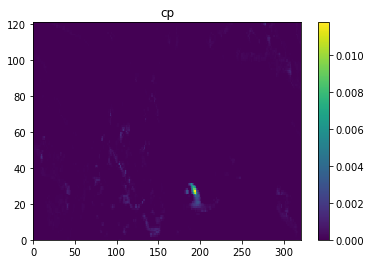

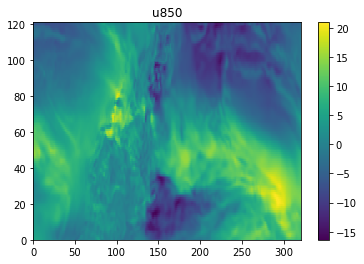

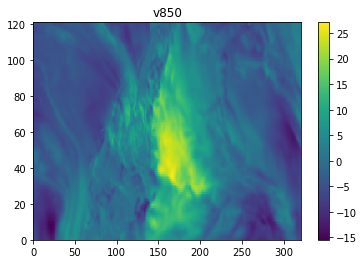

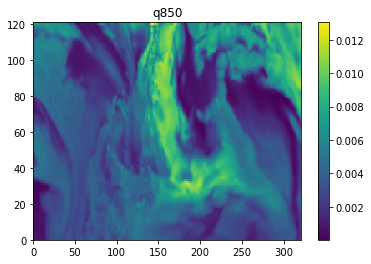

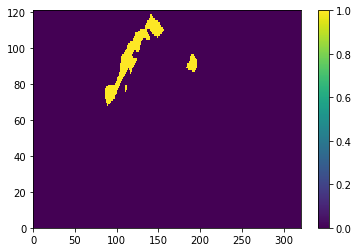

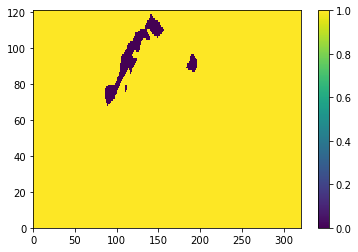

In [7]:
a, b = training_generator.__getitem__(0)

cs = plt.pcolormesh(a[0,:,:,0]); plt.colorbar(cs); plt.title(variables[0]); plt.show()
cs = plt.pcolormesh(a[0,:,:,1]); plt.colorbar(cs); plt.title(variables[1]); plt.show()
cs = plt.pcolormesh(a[0,:,:,2]); plt.colorbar(cs); plt.title(variables[2]); plt.show()
cs = plt.pcolormesh(a[0,:,:,3]); plt.colorbar(cs); plt.title(variables[3]); plt.show()

cs = plt.pcolormesh(b[0,:,:,0]); plt.colorbar(cs); plt.show()
cs = plt.pcolormesh(b[0,:,:,1]); plt.colorbar(cs); plt.show()

## Now, lets build the machine learning model with Keras and train!

Instantiate the ml model class with desired class options and compile the model.

In [8]:
#mlmodel = dlfront_style.DLFrontStyle(variable=variables, learning_rate=0.01, scheduler=1, epochs=30, batch_norm=True, spatial_drop=0.3)
mlmodel = dlfront_style.DLFrontStyle(variable=variables, dim=(121, 321), learning_rate=0.01, epochs=30, batch_norm=True, spatial_drop=0.3)
the_model = mlmodel.compile_model()

Model: "dlfront_style"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 121, 321, 4)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 121, 321, 80)      8080      
_________________________________________________________________
batch_normalization (BatchNo (None, 121, 321, 80)      320       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 121, 321, 80)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 121, 321, 80)      160080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 121, 321, 80)      320       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 121, 321, 80)    

In [9]:
variables = ["cp","u850", "v850", "q850"]
validation_generator = dataloader.DataGenerator(list_IDs = valid_IDs, 
                                                path_dataID = f"{main_path_era}/dl_files/3H/", 
                                                variable = variables, 
                                                h_num = None, height = None, 
                                                batch_size = 16, dim = (121, 321), 
                                                n_channels = len(variables), 
                                                n_classes = 2, shuffle = False,)

In [10]:
mlmodel.train_model(the_model, training_generator, validation=validation_generator)

Epoch 1/30
7/7 [==============================] - 129s 18s/step - loss: 2.9989 - accuracy: 0.6559 - mean_squared_error: 0.3019 - mean_absolute_error: 0.3453 - val_loss: 16.1909 - val_accuracy: 0.0268 - val_mean_squared_error: 0.9732 - val_mean_absolute_error: 0.9732
Epoch 2/30
7/7 [==============================] - 118s 17s/step - loss: 2.4116 - accuracy: 0.8361 - mean_squared_error: 0.1524 - mean_absolute_error: 0.1692 - val_loss: 16.4718 - val_accuracy: 0.0269 - val_mean_squared_error: 0.9730 - val_mean_absolute_error: 0.9731
Epoch 3/30
7/7 [==============================] - 125s 18s/step - loss: 2.1730 - accuracy: 0.9015 - mean_squared_error: 0.0956 - mean_absolute_error: 0.1010 - val_loss: 15.2021 - val_accuracy: 0.1041 - val_mean_squared_error: 0.8945 - val_mean_absolute_error: 0.8958
Epoch 4/30
7/7 [==============================] - 118s 17s/step - loss: 1.8904 - accuracy: 0.9066 - mean_squared_error: 0.0856 - mean_absolute_error: 0.0982 - val_loss: 8.6182 - val_accuracy: 0.4921 

KeyboardInterrupt: 

In [11]:
variables = ["cp","u850", "v850", "q850"]
testing_generator = dataloader.DataGenerator(list_IDs = test_IDs, 
                                             path_dataID = f"{main_path_era}/dl_files/3H/", 
                                             variable = variables, 
                                             h_num = None, height = None, 
                                             batch_size = 32, dim = (121, 321), 
                                             n_channels = len(variables), 
                                             n_classes = 2, shuffle = False,)

In [12]:
y=the_model.predict(x=a[:,:,:,:])

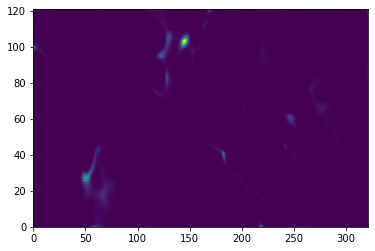

In [22]:
plt.pcolormesh(y[11,:,:,0]); plt.show()

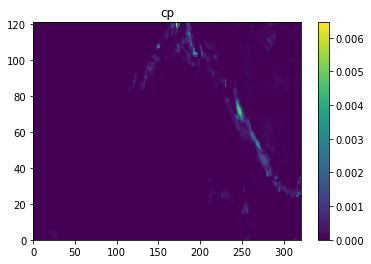

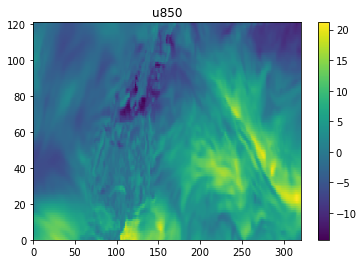

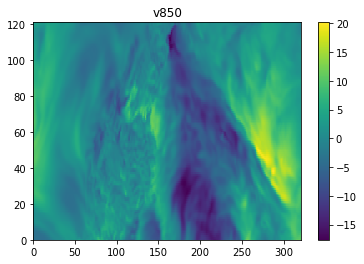

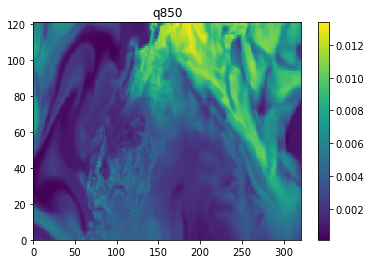

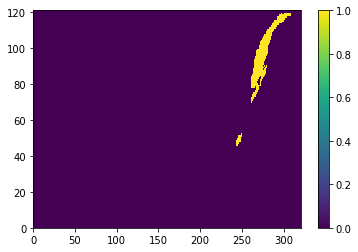

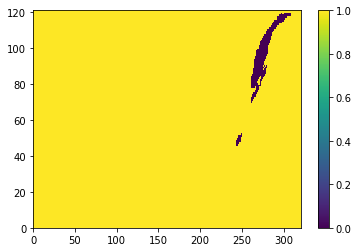

In [23]:
a, b = testing_generator.__getitem__(0)

cs = plt.pcolormesh(a[11,:,:,0]); plt.colorbar(cs); plt.title(variables[0]); plt.show()
cs = plt.pcolormesh(a[11,:,:,1]); plt.colorbar(cs); plt.title(variables[1]); plt.show()
cs = plt.pcolormesh(a[11,:,:,2]); plt.colorbar(cs); plt.title(variables[2]); plt.show()
cs = plt.pcolormesh(a[11,:,:,3]); plt.colorbar(cs); plt.title(variables[3]); plt.show()

cs = plt.pcolormesh(b[11,:,:,0]); plt.colorbar(cs); plt.show()
cs = plt.pcolormesh(b[11,:,:,1]); plt.colorbar(cs); plt.show()

In [8]:
mlmodel = dlfront_style.DLFrontStyle(variable=variables, learning_rate=0.01, scheduler=1, epochs=30, batch_norm=True, spatial_drop=0.3)
the_model = mlmodel.compile_model()

Model: "dlfront_style"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 105, 161, 5)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 105, 161, 80)      10080     
_________________________________________________________________
batch_normalization (BatchNo (None, 105, 161, 80)      320       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 105, 161, 80)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 105, 161, 80)      160080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 105, 161, 80)      320       
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 105, 161, 80)    

### Now, start training!

Should go quick if GPU is available.

In [9]:
mlmodel.train_model(the_model, training_generator)

0.009999999776482582
Epoch 1/30
106/106 [==============================] - 122s 1s/step - loss: 0.8388 - accuracy: 0.8998 - mean_squared_error: 0.0824 - mean_absolute_error: 0.1318
0.009999999776482582
Epoch 2/30
106/106 [==============================] - 117s 1s/step - loss: 0.2128 - accuracy: 0.9678 - mean_squared_error: 0.0314 - mean_absolute_error: 0.0637
0.009999999776482582
Epoch 3/30
106/106 [==============================] - 124s 1s/step - loss: 0.1721 - accuracy: 0.9678 - mean_squared_error: 0.0314 - mean_absolute_error: 0.0639
0.009999999776482582
Epoch 4/30
106/106 [==============================] - 113s 1s/step - loss: 0.1659 - accuracy: 0.9679 - mean_squared_error: 0.0312 - mean_absolute_error: 0.0639
0.009999999776482582
Epoch 5/30
106/106 [==============================] - 113s 1s/step - loss: 0.1672 - accuracy: 0.9679 - mean_squared_error: 0.0312 - mean_absolute_error: 0.0633
0.009999999776482582
Epoch 6/30
106/106 [==============================] - 114s 1s/step - loss:

In [15]:
variables = ["2d","10u","10v", "sp", "2t"]
testing_generator = dataloader.DataGenerator(list_IDs = test_IDs, 
                                              path_dataID = f"{main_path_era}/dl_files/3H/", 
                                              variable = variables, 
                                              ens_num = "era5",
                                              h_num = None, 
                                              height = None, 
                                              batch_size = 32, dim = (105, 161), 
                                              n_channels = len(variables), 
                                              n_classes = 2, shuffle = False,
                                              stats_path = main_path_era, 
                                              norm = 'zscore')

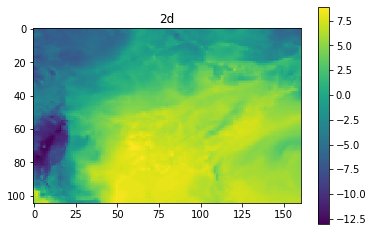

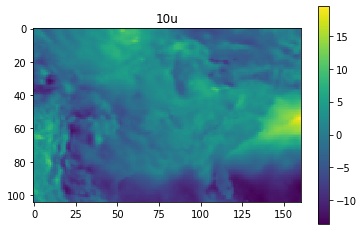

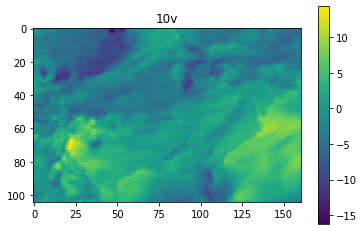

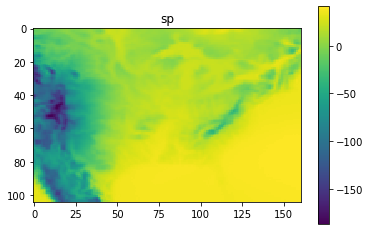

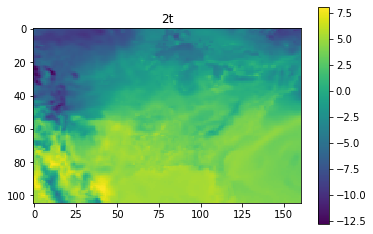

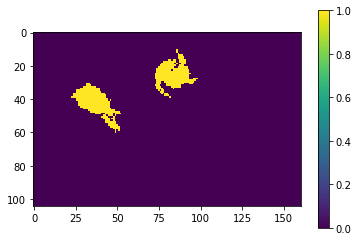

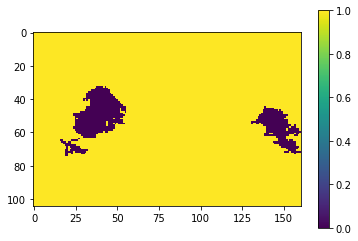

In [49]:
a, b = testing_generator.__getitem__(0)
cs = plt.imshow(a[0,:,:,0]); plt.colorbar(cs); plt.title(variables[0]); plt.show()
cs = plt.imshow(a[0,:,:,1]); plt.colorbar(cs); plt.title(variables[1]); plt.show()
cs = plt.imshow(a[0,:,:,2]); plt.colorbar(cs); plt.title(variables[2]); plt.show()
cs = plt.imshow(a[0,:,:,3]); plt.colorbar(cs); plt.title(variables[3]); plt.show()
cs = plt.imshow(a[0,:,:,4]); plt.colorbar(cs); plt.title(variables[4]); plt.show()
cs = plt.imshow(b[7,:,:,0]); plt.colorbar(cs); plt.show()
cs = plt.imshow(b[0,:,:,1]); plt.colorbar(cs); plt.show()

In [22]:
a[0,:,:,:].shape

(105, 161, 5)

In [35]:
y=the_model.predict(x=a[:,:,:,:])

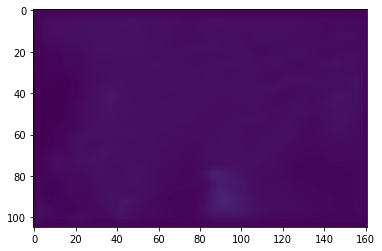

In [48]:
plt.imshow(y[7,:,:,0], vmin=0, vmax=1); 

In [10]:
mlmodel = dlfront_style.DLFrontStyle(variable=variables, learning_rate=0.01, scheduler=1, epochs=30, batch_norm=True, spatial_drop=0.3, 
                                     output_shape=1, output_activation='sigmoid', loss_function='mean_squared_error')
the_model = mlmodel.compile_model()

Model: "dlfront_style"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 105, 161, 5)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 105, 161, 80)      10080     
_________________________________________________________________
batch_normalization_2 (Batch (None, 105, 161, 80)      320       
_________________________________________________________________
spatial_dropout2d_2 (Spatial (None, 105, 161, 80)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 105, 161, 80)      160080    
_________________________________________________________________
batch_normalization_3 (Batch (None, 105, 161, 80)      320       
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 105, 161, 80)    

In [11]:
mlmodel.train_model(the_model, training_generator)

0.009999999776482582
Epoch 1/30
2/2 [==============================] - 1s 599ms/step - loss: 0.3430 - accuracy: 0.7444 - mean_squared_error: 0.1599 - mean_absolute_error: 0.2660
0.009999999776482582
Epoch 2/30
2/2 [==============================] - 1s 552ms/step - loss: 0.2992 - accuracy: 0.9592 - mean_squared_error: 0.0408 - mean_absolute_error: 0.0408
0.009999999776482582
Epoch 3/30
2/2 [==============================] - 1s 555ms/step - loss: 0.3722 - accuracy: 0.9592 - mean_squared_error: 0.0408 - mean_absolute_error: 0.0408
0.009999999776482582
Epoch 4/30
2/2 [==============================] - 1s 547ms/step - loss: 0.4229 - accuracy: 0.9592 - mean_squared_error: 0.0408 - mean_absolute_error: 0.0408
0.009999999776482582
Epoch 5/30
2/2 [==============================] - 1s 539ms/step - loss: 0.4502 - accuracy: 0.9592 - mean_squared_error: 0.0408 - mean_absolute_error: 0.0408
0.009999999776482582
Epoch 6/30
2/2 [==============================] - 1s 550ms/step - loss: 0.4577 - accuracy

KeyboardInterrupt: 